# Creating a simple neural network

In [96]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

In [115]:


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

48000


Text(0.5, 1.0, '6')

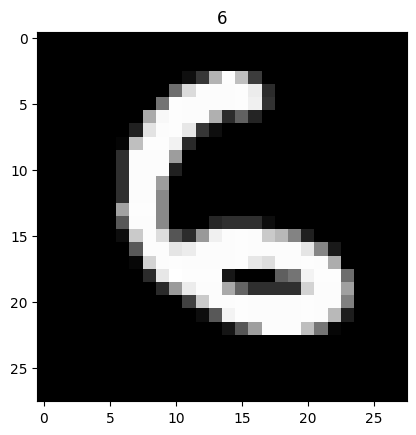

In [116]:
print(len(train_dataset))
plt.imshow(train_dataset[0][0].squeeze(), cmap="gray")
plt.title(str(train_dataset[0][1]))

In [142]:
class MonreseaudeNeurone(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.activation = activation_fn
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(128,128)
        self.fc4 = nn.Linear(128,128)
        self.fc5 = nn.Linear(128,128)
        self.fc6 = nn.Linear(128,128)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input if needed (e.g., for MNIST 28x28 images)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc2(x)


        return x



# Sauvegarder et recharger mon réseau

In [145]:
model = MonreseaudeNeurone(activation_fn=nn.ReLU())
torch.save(model.state_dict(), "./model.pt")
state_dict = torch.load("./model.pt", weights_only=False)

In [146]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [133]:
def training_loop(dataloader,
                  device,
                  optimizer,
                  loss_fn,
                  model,
                  n_epoch ):
    
    iteration_exp = []
    losse_exp = []
    count = 0
    for epoch in range(n_epoch):
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer.zero_grad()  # Reset gradients
            data= data.to(device)              # Put data on device
            target = target.to(device)
            output = model(data)                 # Forward pass
            loss = loss_fn(output, target) # Compute loss
            loss.backward()                      # Compute gradients
            optimizer.step()                     # Update weights

            if batch_idx %100:
                iteration_exp.append(count)
                losse_exp.append(loss.item())
                count+=1

        print(f'Train Epoch: {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
   
    return model, iteration_exp, losse_exp

In [134]:
# Simple function to compute precision given predicted and target tensors
def compute_precision(predicted, target):
    # predicted: tensor of predicted class indices
    # target: tensor of true class indices
    
    true_positives = (predicted == target).sum().item()
    total_predicted = predicted.size(0)
    precision = true_positives / total_predicted if total_predicted > 0 else 0.0
    return precision

In [135]:
def evaluate_precision(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)

            all_preds.append(predicted)
            all_targets.append(targets.to(device))

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    precision = compute_precision(all_preds, all_targets)
    return precision

# Searching for learning rate

In [124]:

loss_function = nn.CrossEntropyLoss()



# Training loop
epochs = 5
iterations = {}
losses = {}

for lr in [1.0,0.1,0.01,0.001,0.0001]:
    print("=="*50)
    print(f"lr : {lr}")
    print("=="*50)
    model = MonreseaudeNeurone()
    model.load_state_dict(state_dict())
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    iteration_exp = []
    losse_exp = []
    count = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()  # Reset gradients
            data= data.to(device)              # Put data on device
            target = target.to(device)
            output = model(data)                 # Forward pass
            loss = loss_function(output, target) # Compute loss
            loss.backward()                      # Compute gradients
            optimizer.step()                     # Update weights

            if batch_idx %100:
                iteration_exp.append(count)
                losse_exp.append(loss.item())
                count+=1
        
        precision = evaluate_precision(model,val_loader)

        print(f'Train Epoch: {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f} Precision : {precision:.6f}')
    losses[lr] = losse_exp
    iterations[lr] = iteration_exp

lr : 1.0
Train Epoch: 1 [47936/48000] Loss: 2.339282 Precision : 0.102583
Train Epoch: 2 [47936/48000] Loss: 2.310319 Precision : 0.094083
Train Epoch: 3 [47936/48000] Loss: 2.273666 Precision : 0.095417
Train Epoch: 4 [47936/48000] Loss: 2.381021 Precision : 0.098583
Train Epoch: 5 [47936/48000] Loss: 2.355202 Precision : 0.102583
lr : 0.1
Train Epoch: 1 [47936/48000] Loss: 0.254628 Precision : 0.926833
Train Epoch: 2 [47936/48000] Loss: 0.204828 Precision : 0.936417
Train Epoch: 3 [47936/48000] Loss: 0.175918 Precision : 0.943250
Train Epoch: 4 [47936/48000] Loss: 0.217262 Precision : 0.944500
Train Epoch: 5 [47936/48000] Loss: 0.180849 Precision : 0.943417
lr : 0.01
Train Epoch: 1 [47936/48000] Loss: 0.063807 Precision : 0.952167
Train Epoch: 2 [47936/48000] Loss: 0.058562 Precision : 0.963083
Train Epoch: 3 [47936/48000] Loss: 0.034178 Precision : 0.967000
Train Epoch: 4 [47936/48000] Loss: 0.086274 Precision : 0.970833
Train Epoch: 5 [47936/48000] Loss: 0.043937 Precision : 0.9717

In [147]:
loss_function = nn.CrossEntropyLoss()



# Training loop
epochs = 5
iterations = {}
losses = {}
lr = 0.01
activations = ["relu", "sigmoid","Tanh"]

for act_idx, activation in enumerate([nn.ReLU(), nn.Sigmoid(), nn.Tanh()]):
    print("=="*50)
    print(f"activation : {activations[act_idx]}")
    print("=="*50)
    model = MonreseaudeNeurone(activation_fn=activation)
    model.load_state_dict(state_dict)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    iteration_exp = []
    losse_exp = []
    count = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()  # Reset gradients
            data= data.to(device)              # Put data on device
            target = target.to(device)
            output = model(data)                 # Forward pass
            loss = loss_function(output, target) # Compute loss
            loss.backward()                      # Compute gradients
            optimizer.step()                     # Update weights

            if batch_idx %100:
                iteration_exp.append(count)
                losse_exp.append(loss.item())
                count+=1
        
        precision = evaluate_precision(model,val_loader)

        print(f'Train Epoch: {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f} Precision : {precision:.6f}')
    losses[activations[act_idx]] = losse_exp
    iterations[activations[act_idx]] = iteration_exp

activation : relu
Train Epoch: 1 [47936/48000] Loss: 0.166961 Precision : 0.939333
Train Epoch: 2 [47936/48000] Loss: 0.113535 Precision : 0.958833
Train Epoch: 3 [47936/48000] Loss: 0.029095 Precision : 0.964333
Train Epoch: 4 [47936/48000] Loss: 0.050059 Precision : 0.969250
Train Epoch: 5 [47936/48000] Loss: 0.112434 Precision : 0.969417
activation : sigmoid
Train Epoch: 1 [47936/48000] Loss: 2.302234 Precision : 0.097417
Train Epoch: 2 [47936/48000] Loss: 2.304826 Precision : 0.103333
Train Epoch: 3 [47936/48000] Loss: 2.338292 Precision : 0.113083
Train Epoch: 4 [47936/48000] Loss: 2.301615 Precision : 0.102167
Train Epoch: 5 [47936/48000] Loss: 2.314324 Precision : 0.097417
activation : Tanh
Train Epoch: 1 [47936/48000] Loss: 0.325632 Precision : 0.947833
Train Epoch: 2 [47936/48000] Loss: 0.066344 Precision : 0.960333
Train Epoch: 3 [47936/48000] Loss: 0.166617 Precision : 0.963917
Train Epoch: 4 [47936/48000] Loss: 0.144177 Precision : 0.966667
Train Epoch: 5 [47936/48000] Loss

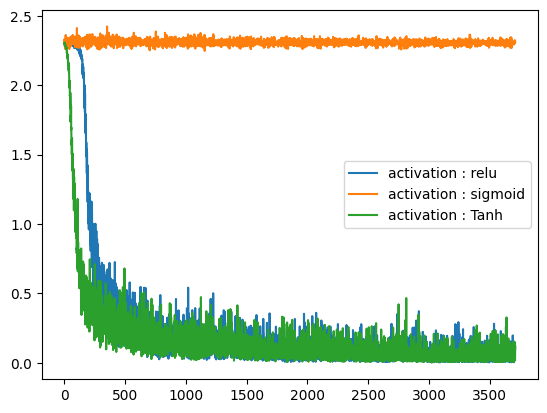

In [148]:
plt.gca()
for key, value in losses.items():

    plt.plot(iterations[key],value,label = "activation : " + str(key))
plt.legend()

In [151]:
loss_function = nn.CrossEntropyLoss()



# Training loop
epochs = 5
iterations = {}
losses = {}
lr = 0.01
optimizers_name = ["adam","sgd+momentum", "sgd", ]

for act_idx, optimizer_func in enumerate(optimizers_name):
    print("=="*50)
    print(f"activation : {optimizers_name[act_idx]}")
    print("=="*50)
    model = MonreseaudeNeurone(activation_fn=nn.ReLU())
    model.load_state_dict(state_dict)
    model.to(device)
    model.train()
    if optimizer_func == "sgd+momentum":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_func =="adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_func == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)



    iteration_exp = []
    losse_exp = []
    count = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()  # Reset gradients
            data= data.to(device)              # Put data on device
            target = target.to(device)
            output = model(data)                 # Forward pass
            loss = loss_function(output, target) # Compute loss
            loss.backward()                      # Compute gradients
            optimizer.step()                     # Update weights

            if batch_idx %100:
                iteration_exp.append(count)
                losse_exp.append(loss.item())
                count+=1
        
        precision = evaluate_precision(model,val_loader)

        print(f'Train Epoch: {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f} Precision : {precision:.6f}')
    losses[optimizer_func[act_idx]] = losse_exp
    iterations[optimizer_func[act_idx]] = iteration_exp

activation : sgd+momentum
Train Epoch: 1 [47936/48000] Loss: 0.310182 Precision : 0.943583
Train Epoch: 2 [47936/48000] Loss: 0.233555 Precision : 0.957250
Train Epoch: 3 [47936/48000] Loss: 0.065067 Precision : 0.965333
Train Epoch: 4 [47936/48000] Loss: 0.228254 Precision : 0.964667
Train Epoch: 5 [47936/48000] Loss: 0.122051 Precision : 0.967250
activation : sgd
Train Epoch: 1 [47936/48000] Loss: 0.890596 Precision : 0.734500
Train Epoch: 2 [47936/48000] Loss: 0.644165 Precision : 0.880000
Train Epoch: 3 [47936/48000] Loss: 0.201416 Precision : 0.913417
Train Epoch: 4 [47936/48000] Loss: 0.150574 Precision : 0.930500
Train Epoch: 5 [47936/48000] Loss: 0.218947 Precision : 0.939833
activation : adam
Train Epoch: 1 [47936/48000] Loss: 0.469323 Precision : 0.835167
Train Epoch: 2 [47936/48000] Loss: 0.497137 Precision : 0.821667


KeyboardInterrupt: 

In [103]:

plt.gca()
for key, value in losses.items():

    plt.plot(iterations[key],value,label = "activation : " + str(key))
plt.legend()

In [105]:
evaluate_precision(model, val_loader)

0.708